# Alloe Draft Segmentation

Objectives:

* **Create meaningful Alloe user segments.** Initial conversations with Alloe team indicated potentially 4 segments based on user varying levels activity the model will be designed to partition by:
    * Dead Users
    * Normal Users
    * Active Users
    * VIP Users
    
    
* **Use segments as a means to:**
    * "Resurrect" Dead Users via carrot/stick messaging
    * Create a means of customizing Alloe to engage different user types

## Data from mongoDB 

Data obtained from Alloe mondoDB on 10.18.17 via the Studio 3T GUI. In the future many of these initial table joins might be more appropriately performed within the mongoDB environment rather than in Python/Jupyter.

In [303]:
import os
import re
import glob
import itertools
import pandas as pd

#Loads 23 tables into memory
path = 'C:/analyticsdev/Projects/EXPECTEDX/Alloe/data'
files = glob.glob(os.path.join(path, "*.csv"))

#Stores 23 tables in dictionary with file name as key
raw_data = [pd.read_csv(name) for name in files]
df_names = [re.findall('(?<=\.)[a-zA-Z]+(?=\.)', names) for names in files]
df_names = itertools.chain(*df_names)
raw_data = dict(zip(df_names, raw_data))

mongoDB contains 23 collections (i.e. tables) of Alloe user and usage data. Tables belong to one of three categories for this exercise: data, meta, uninformative.

* **Data** - Usable data for segmentation purposes.
* **Meta** - Data describing what is found in "Data" tables with more detail.
* **Uninformative** - Data regarding Alloe security, device connections, etc.

## Functions

In [401]:
#Functions for building and mergeing tables for segmentation
aggfunc = lambda x: ' '.join(str(v) for v in x)

def make_tables(table, clean_cols, piv_col, piv_val, suffix, piv_index='user', piv_func=aggfunc, counter=False):
    df = raw_data[table]
    #Add counter for summing CheckIns
    if counter:
        df['counter'] = int(1)
    #Remove "@..." from id columns    
    for col in clean_cols:
        df[col] = df[col].apply(lambda x: re.split(' (?=@)',x)[0])
    df = df.pivot_table(index=piv_index, 
                        columns=piv_col, 
                        values=piv_val, 
                        aggfunc=piv_func)
    df = df.add_suffix(suffix)
    return df

def merge_tables(tables, usertable):
    df = usertable
    for table in tables:
        df = df.merge(table,
                      how='left',
                      left_on='_id',
                      right_index=True,
                      sort=True)
    return df

## Preprocessing

Tables are created to summarize different Meta data that can later be linked back to labeled segments. For example, "friends" can be linked via the "frnd_rq" table (short for "Friend Request"). This can address the second objective of resurrecting Dead Users by messaging them about the accomplishments of their more active friends. This can be designed as a motivator.

In [402]:
#Prepare 'Data' tables
answer = make_tables('answer', 
                     clean_cols=['survey','user'], 
                     piv_col='survey', 
                     piv_val='answer',
                     suffix='_surv')

chal_inv = make_tables('challengeInvitation',
                       clean_cols=['challenge','friend','user'],
                       piv_col='challenge',
                       piv_val='friend',
                       suffix='_chalinv')

frnd_rq = make_tables('friendship',
                      clean_cols=['friend','user'],
                      piv_col='friend',
                      piv_val='status',
                      suffix='_frndid')

event_ast = make_tables('assistantEvent',
                        clean_cols=['event','user'],
                        piv_col='event',
                        piv_val='_id',
                        suffix='_evntid')

post = make_tables('post',
                   clean_cols=['user','item._class'],
                   piv_col='item._class',
                   piv_val='counter',
                   piv_func='sum',
                   counter=True,
                   suffix='')

#Give columns clean names
post.rename(columns=lambda x: re.sub('[a-z].+\.(?=[A-Z])', '', str(x)), inplace=True)

The "user" table holds demographic information about each user in the Alloe mongoDB and will act as the main table other tables are joined to below.

In [403]:
from datetime import datetime, date
from dateutil import relativedelta

#Create user 'Data' table and append new 'age' and 'active time' features
user = raw_data['user'][['_id',
                         'active',
                         'dob',
                         'gender',
                         'heightFeet',
                         'heightInches',
                         'joined',
                         'weight']]

user['dob'] = user['dob'].apply(lambda x: pd.to_datetime(x))
user['age'] = user['dob'].apply(lambda x: relativedelta.relativedelta(date.today(), datetime.date(x)).years)
user['joined'] = user['joined'].apply(lambda x: pd.to_datetime(x))
user['active_time'] = user['joined'].apply(lambda x: (date.today() - datetime.date(x)).days)

Features below are engineered to be in a more useful format for segmentation purposes.

In [404]:
#Create additional tables of miles ran, activity time, and yoga positions held
act_measures = raw_data['post'][['user','item.miles','item.time','item.positions']]
act_measures =  act_measures.groupby(act_measures['user']).sum()

#Count exercise types
exercises = raw_data['post'][['user','item.exercise']]
exercises['counter'] = int(1)
exercises = exercises.pivot_table(index='user',
                                  columns='item.exercise',
                                  values='counter',
                                  aggfunc='sum')

#Count challenges sent, unique friends challenged, and ratio between
challenges = pd.DataFrame(chal_inv.count(axis=1), columns={'chal_sent'})
challenges = challenges.join(pd.DataFrame(chal_inv.nunique(axis=1), columns={'chal_unique'}))
challenges['chal_uni_frnd'] =  challenges['chal_sent'] / challenges['chal_unique']

#Count friend requests sent and request status
friends = pd.DataFrame(frnd_rq.count(axis=1), columns={'frnd_sent'})
friends = friends.join(frnd_rq.apply(pd.value_counts, axis=1)[['ACCEPTED','PENDING','WAITING']])

Data tables for segmentation are joined by user ID and various final cleaning steps are performed.

In [405]:
import numpy as np

#Create main data set for segmentation
main = merge_tables([post, act_measures, exercises, challenges, friends], user)

main.drop(353, inplace=True) #Remove one all NaN record
main.drop(['dob','joined','CompanyMessage','active'], axis=1, inplace=True) #Remove unused columns
main[['heightFeet','heightInches','weight']] = main[['heightFeet','heightInches','weight']].fillna(main.median()) #Replace height/weight NaNs with median
main.replace({'gender':{'MALE': 1, 'FEMALE': 2, np.nan: 0}}, inplace=True) #Gender to integer
main.fillna(0, inplace=True) #Replace other NaNs with zero 
main.set_index('_id', inplace=True)

**NOTE**: Due to relatively few samples, all are used in building the segmentation model even those with outliers. The table below shows that the "max" values for some measures like 'weight' and 'height' are clearly beyond reasonable. Alloe may consider restrictions on inputs for these in the future

In [407]:
main.describe()

,gender,heightFeet,heightInches,weight,age,active_time,Challenger,MovesChallenge,PictureChallenge,BloodPressureCheckIn,...,OTHER,SWIMMING,WEIGHTS,chal_sent,chal_unique,chal_uni_frnd,frnd_sent,ACCEPTED,PENDING,WAITING
count,590.000000,590.000000,590.000000,590.000000,590.000000,590.000000,590.000000,590.000000,590.000000,590.000000,...,590.000000,590.000000,590.000000,590.000000,590.000000,590.000000,590.000000,590.000000,590.000000,590.000000
mean,1.355932,5.286441,6.042373,173.418907,31.408475,606.144068,1.510169,0.018644,0.010169,0.113559,...,14.759322,0.750847,7.711864,0.279661,0.205085,0.222599,14.308475,7.542373,3.376271,3.376271
std,0.563843,2.248784,4.197974,249.012819,9.583389,295.883325,2.622690,0.213289,0.129901,0.516932,...,53.163135,8.396415,36.063400,0.744939,0.521498,0.573973,35.479061,18.761683,5.161314,19.630391
min,0.000000,3.000000,0.000000,15.000000,0.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,5.000000,4.000000,147.000000,28.000000,342.250000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,5.000000,6.000000,160.000000,31.000000,616.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,1.000000,1.000000,0.000000
75%,2.000000,5.000000,8.000000,175.000000,35.000000,928.000000,2.000000,0.000000,0.000000,0.000000,...,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.000000,6.000000,6.000000,0.000000
max,2.000000,55.000000,68.000000,6158.000000,70.000000,985.000000,26.000000,4.000000,2.000000,10.000000,...,648.000000,177.000000,402.000000,5.000000,3.000000,4.000000,351.000000,222.000000,36.000000,288.000000


## Segmentation

Before attempting segmentation, we need to apply transformations to the data set. Alloe data is sparse, or, most features are zeros/missing across users. For example, if a user never has done a "Gym Check In" the value will be a zero in the table we use for segmentation. 

Since each feature is on a different scale (i.e. 'age' could be '18-99' but 'weight' could be '100-400'), before we segment we need to transform them to be roughly equivalent or our segmentation model might be driven by only one feature with the greatest variation. The Maximum Absolute Value technique sets the highest (absolute) value of a feature to "1", lowest (absolute) value to "0" and scales all other values as a distribution between the two. This doesn't shift the center (mean) of the data and preserves the sparsity mentioned above.

In [318]:
from sklearn.preprocessing import MaxAbsScaler

#Rescaling - Max Absolute Value scaling due to sparse data
mas = MaxAbsScaler()
processed = pd.DataFrame(mas.fit_transform(main), columns=main.columns, index=main.index)

The data set contains 35 features (columns) to segment on. High-dimension data is difficult to interpret let alone visualize. The t-SNE algorithm compresses high-dimensional data into a lower dimensional representation while preserving the distances between each sample (user). This is similar to Principal Components Analysis (PCA) but is more robust to data that is non-linear.

The algorithm run below produces a 2D visualization of our 35-dimensional data set. From initial inspection, it seems that 3, possibly 2 segments might be better than 4.

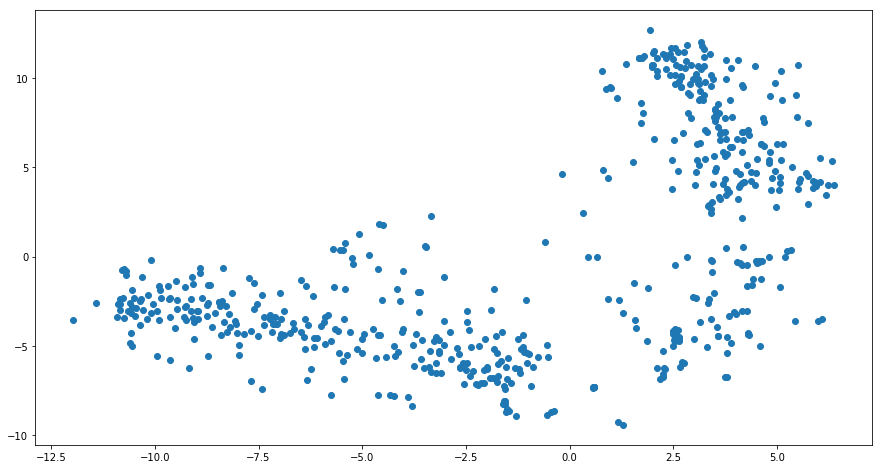

In [408]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

#Embed higher dimensional data into 2-dimensional space using t-distributed Stochastic Neighbor Embedding
embed = TSNE(2, perplexity=100, learning_rate=500).fit_transform(processed)

plt.figure(figsize=(15,8))
plt.scatter(embed[:,0],embed[:,1])

Clustering (segmentation) algorithms use a variety of techniques. Some require the number of clusters to be defined before running (e.g. K-Means, Agglomerative, Spectral) while others define clusters themselves based on how the data is structured. As with most ML applications, it's best practice to try a variety of algorithms to see which works best.

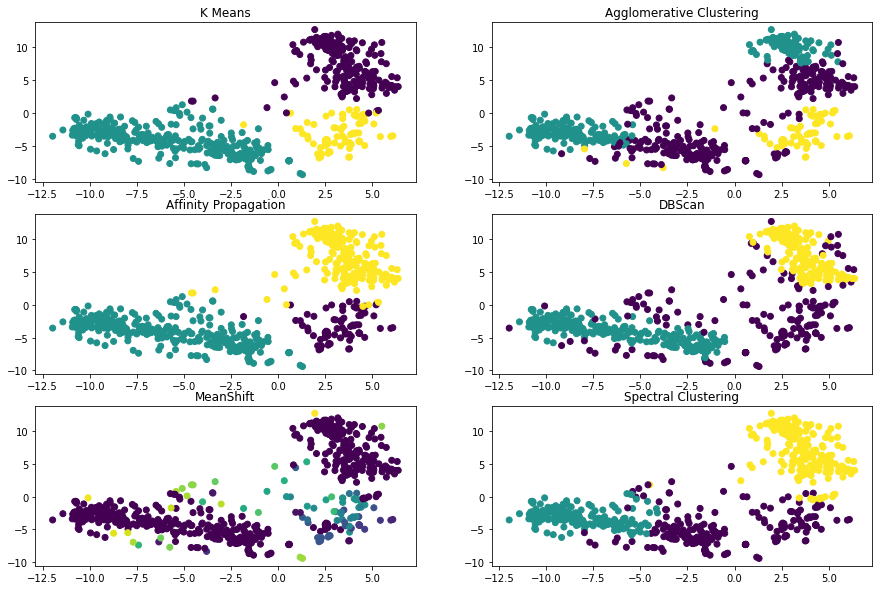

In [412]:
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation, DBSCAN, MeanShift, SpectralClustering

#Test 6 clustering algorithms
km = KMeans(n_clusters=3, random_state=734) #Random state for reproducability
ac = AgglomerativeClustering(n_clusters=3)
ap = AffinityPropagation(damping=.85, preference=-30)
db = DBSCAN(eps=.3, min_samples=25)
ms = MeanShift()
sc = SpectralClustering(n_clusters=3)

#Predict cluster label for each user using each algorithm
algos = [km, ac, ap, db, ms, sc]
preds = [algo.fit_predict(processed) for algo in algos]

#Plot results
fig, axes = plt.subplots(3, 2, figsize=(15,10))
axes[0,0].scatter(embed[:,0], embed[:,1], c = preds[0])
axes[0,0].set_title('K Means')
axes[0,1].scatter(embed[:,0], embed[:,1], c = preds[1])
axes[0,1].set_title('Agglomerative Clustering')
axes[1,0].scatter(embed[:,0], embed[:,1], c = preds[2])
axes[1,0].set_title('Affinity Propagation')
axes[1,1].scatter(embed[:,0], embed[:,1], c = preds[3])
axes[1,1].set_title('DBScan')
axes[2,0].scatter(embed[:,0], embed[:,1], c = preds[4])
axes[2,0].set_title('MeanShift')
axes[2,1].scatter(embed[:,0], embed[:,1], c = preds[5])
axes[2,1].set_title('Spectral Clustering')
plt.show()

## Evaluation

Each resulting clustering/segmentation produces slightly different results with some better than others based on visual inspection alone. For example, both K-Means and Affinity Propagation produce good (and nearly identical) clusters while MeanShift seemingly fails.

Rather than simply visually inspecting results, both the Silhouette and Calinski-Harabaz scores can be calculated to quantify the strength of the clustering. Since this exercise is "unsupervised" meaning we don't know the ground truth for which segment a user is "supposed" to belong to, these metrics provide a means of measuring how tightly packed a cluster is and how great the separation is between itself and other clusters. 

* A Silhouette Score close to "1" indicates good clustering, close to "0" indicates clusters are overlapping, and close to "-1" indicates that users within clusters might be wrongly grouped and belong in the next nearest cluster.

* A Calinski-Harabaz Score is used to compare multiple clustering algorithms. The highest value in a group indicates the best relative performer, but there is no threshold value for what is considered a good model.

In [413]:
from sklearn.metrics import silhouette_score, calinski_harabaz_score

#Evaluate strength of clustering assignments - Silhouette
sil_scores = [silhouette_score(processed, pred) for pred in preds]
sil_scores = dict(zip(['K Means','Agglomerative Clustering','Affinity Propagation','DBScan', 'MeanShift','Spectral Clustering'], sil_scores))
sil_scores

{'Affinity Propagation': 0.23911426614377682,
 'Agglomerative Clustering': 0.18876055440759062,
 'DBScan': 0.17708506019171871,
 'K Means': 0.23891444123346589,
 'MeanShift': 0.2045335561503972,
 'Spectral Clustering': 0.19246944590533904}

In [414]:
#Evaluate strength of clustering assignments - Silhouette
ch_scores = [calinski_harabaz_score(processed, pred) for pred in preds]
ch_scores = dict(zip(['K Means','Agglomerative Clustering','Affinity Propagation','DBScan', 'MeanShift','Spectral Clustering'], ch_scores))
ch_scores

{'Affinity Propagation': 138.32024540701133,
 'Agglomerative Clustering': 113.11075452815577,
 'DBScan': 84.657875288001037,
 'K Means': 138.40573523800489,
 'MeanShift': 12.015475230262215,
 'Spectral Clustering': 112.27664133124421}

Both metrics indicate that K-Means and Affinity Propagation are doing the best out of the six candidate models.

We can append the segment labels obtained from each algorithm back to the original, unprocessed data set and review summary statistics for each to determine what measures best describe clusters and differentiate between them.

In [436]:
#Append cluster labels to main data frame
main['km_label'] = preds[0]
main['ac_label'] = preds[1]
main['ap_label'] = preds[2]
main['db_label'] = preds[3]
main['ms_label'] = preds[4]
main['sc_label'] = preds[5]

In [437]:
ap_stats = main.groupby('ap_label')
ap_stats.describe().stack()

ACCEPTED  BloodPressureCheckIn      CARDIO  Challenger  \
ap_label                                                                   
0        count  89.000000   89.000000             89.000000   89.000000    
         mean   32.415730   0.426966              12.213483   4.617978     
         std    36.216461   1.156873              41.495200   4.302498     
         min    1.000000    0.000000              0.000000    0.000000     
         25%    9.000000    0.000000              0.000000    2.000000     
         50%    21.000000   0.000000              0.000000    3.000000     
         75%    43.000000   1.000000              1.000000    5.000000     
         max    222.000000  10.000000             242.000000  26.000000    
1        count  289.000000  289.000000            289.000000  289.000000   
         mean   2.519031    0.051903              3.498270    0.854671     
         std    7.865657    0.237328              22.066837   1.842681     
         min    0.000000    0.000000              0.000000    0.000000     
         25%    0.000000    0.000000              0.000000    0.000000     
         50%    0.000000    0.000000              0.000000    0.000000     
         75%    2.000000    0.000000              0.000000    1.000000     
         max    101.000000  2.000000              337.000000  25.000000    
2        count  212.000000  212.000000            212.000000  212.000000   
         mean   3.948113    0.066038              2.509434    1.099057     
         std    6.528258    0.248936              11.172703   1.419098     
         min    0.000000    0.000000              0.000000    0.000000     
         25%    0.000000    0.000000              0.000000    0.000000     
         50%    1.000000    0.000000              0.000000    1.000000     
         75%    6.000000    0.000000              0.000000    2.000000     
         max    45.000000   1.000000              133.000000  7.000000     

                CholesterolCheckIn  EventCheckIn     FITNESS  FitbitCheckIn  \
ap_label                                                                      
0        count  89.000000           89.000000     89.000000   89.000000       
         mean   0.056180            16.606742     6.370787    3.494382        
         std    0.314771            33.274894     25.335648   10.502298       
         min    0.000000            0.000000      0.000000    0.000000        
         25%    0.000000            0.000000      0.000000    0.000000        
         50%    0.000000            0.000000      0.000000    0.000000        
         75%    0.000000            15.000000     0.000000    0.000000        
         max    2.000000            172.000000    186.000000  77.000000       
1        count  289.000000          289.000000    289.000000  289.000000      
         mean   0.013841            1.453287      2.051903    0.089965        
         std    0.185822            7.271429      16.783778   1.098706        
         min    0.000000            0.000000      0.000000    0.000000        
         25%    0.000000            0.000000      0.000000    0.000000        
         50%    0.000000            0.000000      0.000000    0.000000        
         75%    0.000000            0.000000      0.000000    0.000000        
         max    3.000000            97.000000     254.000000  18.000000       
2        count  212.000000          212.000000    212.000000  212.000000      
         mean   0.000000            4.443396      2.075472    0.617925        
         std    0.000000            13.132991     7.920455    3.574563        
         min    0.000000            0.000000      0.000000    0.000000        
         25%    0.000000            0.000000      0.000000    0.000000        
         50%    0.000000            0.000000      0.000000    0.000000        
         75%    0.000000            2.000000      0.000000    0.000000        
         max    0.000000            96.000000     64.000000   29.0

In [438]:
km_stats = main.groupby('km_label')
km_stats.describe().stack()

ACCEPTED  BloodPressureCheckIn      CARDIO  Challenger  \
km_label                                                                   
0        count  211.000000  211.000000            211.000000  211.000000   
         mean   3.876777    0.061611              2.521327    1.094787     
         std    6.460428    0.241020              11.197928   1.421107     
         min    0.000000    0.000000              0.000000    0.000000     
         25%    0.000000    0.000000              0.000000    0.000000     
         50%    1.000000    0.000000              0.000000    1.000000     
         75%    6.000000    0.000000              0.000000    2.000000     
         max    45.000000   1.000000              133.000000  7.000000     
1        count  289.000000  289.000000            289.000000  289.000000   
         mean   2.519031    0.051903              3.498270    0.854671     
         std    7.865657    0.237328              22.066837   1.842681     
         min    0.000000    0.000000              0.000000    0.000000     
         25%    0.000000    0.000000              0.000000    0.000000     
         50%    0.000000    0.000000              0.000000    0.000000     
         75%    2.000000    0.000000              0.000000    1.000000     
         max    101.000000  2.000000              337.000000  25.000000    
2        count  90.000000   90.000000             90.000000   90.000000    
         mean   32.266667   0.433333              12.077778   4.588889     
         std    36.040177   1.151940              41.281502   4.287149     
         min    1.000000    0.000000              0.000000    0.000000     
         25%    9.250000    0.000000              0.000000    2.000000     
         50%    20.500000   0.000000              0.000000    3.000000     
         75%    42.250000   1.000000              1.000000    5.000000     
         max    222.000000  10.000000             242.000000  26.000000    

                CholesterolCheckIn  EventCheckIn     FITNESS  FitbitCheckIn  \
km_label                                                                      
0        count  211.000000          211.000000    211.000000  211.000000      
         mean   0.000000            4.402844      2.075829    0.620853        
         std    0.000000            13.150911     7.939289    3.582808        
         min    0.000000            0.000000      0.000000    0.000000        
         25%    0.000000            0.000000      0.000000    0.000000        
         50%    0.000000            0.000000      0.000000    0.000000        
         75%    0.000000            1.500000      0.000000    0.000000        
         max    0.000000            96.000000     64.000000   29.000000       
1        count  289.000000          289.000000    289.000000  289.000000      
         mean   0.013841            1.453287      2.051903    0.089965        
         std    0.185822            7.271429      16.783778   1.098706        
         min    0.000000            0.000000      0.000000    0.000000        
         25%    0.000000            0.000000      0.000000    0.000000        
         50%    0.000000            0.000000      0.000000    0.000000        
         75%    0.000000            0.000000      0.000000    0.000000        
         max    3.000000            97.000000     254.000000  18.000000       
2        count  90.000000           90.000000     90.000000   90.000000       
         mean   0.055556            16.566667     6.322222    3.455556        
         std    0.313054            33.089613     25.197123   10.449624       
         min    0.000000            0.000000      0.000000    0.000000        
         25%    0.000000            0.000000      0.000000    0.000000        
         50%    0.000000            0.500000      0.000000    0.000000        
         75%    0.000000            14.500000     0.750000    0.000000        
         max    2.000000            172.000000    186.000000  77.0

In [439]:
ac_stats = main.groupby('ac_label')
ac_stats.describe().stack()

ACCEPTED  BloodPressureCheckIn      CARDIO  Challenger  \
ac_label                                                                   
0        count  286.000000  286.000000            286.000000  286.000000   
         mean   6.321678    0.111888              7.265734    1.377622     
         std    11.355562   0.326704              32.586716   2.116946     
         min    0.000000    0.000000              0.000000    0.000000     
         25%    0.000000    0.000000              0.000000    0.000000     
         50%    2.000000    0.000000              0.000000    1.000000     
         75%    7.000000    0.000000              0.000000    2.000000     
         max    90.000000   2.000000              337.000000  25.000000    
1        count  226.000000  226.000000            226.000000  226.000000   
         mean   0.707965    0.000000              1.181416    0.597345     
         std    1.687504    0.000000              4.965464    1.071569     
         min    0.000000    0.000000              0.000000    0.000000     
         25%    0.000000    0.000000              0.000000    0.000000     
         50%    0.000000    0.000000              0.000000    0.000000     
         75%    0.000000    0.000000              0.000000    1.000000     
         max    11.000000   0.000000              45.000000   9.000000     
2        count  78.000000   78.000000             78.000000   78.000000    
         mean   31.820513   0.448718              3.653846    4.641026     
         std    38.304909   1.223657              12.277978   4.498122     
         min    0.000000    0.000000              0.000000    0.000000     
         25%    9.000000    0.000000              0.000000    2.000000     
         50%    19.000000   0.000000              0.000000    3.000000     
         75%    41.500000   1.000000              1.000000    5.000000     
         max    222.000000  10.000000             88.000000   26.000000    

                CholesterolCheckIn  EventCheckIn     FITNESS  FitbitCheckIn  \
ac_label                                                                      
0        count  286.000000          286.000000    286.000000  286.000000      
         mean   0.000000            4.898601      3.937063    0.608392        
         std    0.000000            14.813704     21.142363   3.460119        
         min    0.000000            0.000000      0.000000    0.000000        
         25%    0.000000            0.000000      0.000000    0.000000        
         50%    0.000000            0.000000      0.000000    0.000000        
         75%    0.000000            2.000000      0.000000    0.000000        
         max    0.000000            105.000000    254.000000  29.000000       
1        count  226.000000          226.000000    226.000000  226.000000      
         mean   0.000000            1.035398      0.738938    0.000000        
         std    0.000000            5.187899      4.016409    0.000000        
         min    0.000000            0.000000      0.000000    0.000000        
         25%    0.000000            0.000000      0.000000    0.000000        
         50%    0.000000            0.000000      0.000000    0.000000        
         75%    0.000000            0.000000      0.000000    0.000000        
         max    0.000000            51.000000     40.000000   0.000000        
2        count  78.000000           78.000000     78.000000   78.000000       
         mean   0.115385            15.448718     3.935897    3.769231        
         std    0.482977            33.044106     16.037569   10.986323       
         min    0.000000            0.000000      0.000000    0.000000        
         25%    0.000000            0.000000      0.000000    0.000000        
         50%    0.000000            0.000000      0.000000    0.000000        
         75%    0.000000            11.500000     0.000000    0.000000        
         max    3.000000            172.000000    107.000000  77.0

In [440]:
db_stats = main.groupby('db_label')
db_stats.describe().stack()

ACCEPTED  BloodPressureCheckIn      CARDIO  Challenger  \
db_label                                                                   
-1       count  187.000000  187.000000            187.000000  187.000000   
         mean   19.315508   0.251337              11.647059   3.326203     
         std    29.545881   0.839826              40.329603   3.841694     
         min    0.000000    0.000000              0.000000    0.000000     
         25%    2.000000    0.000000              0.000000    1.000000     
         50%    9.000000    0.000000              0.000000    3.000000     
         75%    22.000000   0.000000              1.000000    4.000000     
         max    222.000000  10.000000             337.000000  26.000000    
 0       count  233.000000  233.000000            233.000000  233.000000   
         mean   1.678112    0.042918              0.914163    0.566524     
         std    3.834316    0.223325              4.302307    0.949634     
         min    0.000000    0.000000              0.000000    0.000000     
         25%    0.000000    0.000000              0.000000    0.000000     
         50%    0.000000    0.000000              0.000000    0.000000     
         75%    2.000000    0.000000              0.000000    1.000000     
         max    30.000000   2.000000              45.000000   9.000000     
 1       count  170.000000  170.000000            170.000000  170.000000   
         mean   2.629412    0.058824              1.405882    0.805882     
         std    4.558400    0.235989              4.572230    1.056381     
         min    0.000000    0.000000              0.000000    0.000000     
         25%    0.000000    0.000000              0.000000    0.000000     
         50%    0.000000    0.000000              0.000000    0.000000     
         75%    5.000000    0.000000              0.000000    1.000000     
         max    22.000000   1.000000              36.000000   5.000000     

                CholesterolCheckIn  EventCheckIn     FITNESS  FitbitCheckIn  \
db_label                                                                      
-1       count  187.000000          187.000000    187.000000  187.000000      
         mean   0.048128            12.187166     6.556150    2.422460        
         std    0.315946            27.541801     27.350784   8.275377        
         min    0.000000            0.000000      0.000000    0.000000        
         25%    0.000000            0.000000      0.000000    0.000000        
         50%    0.000000            0.000000      0.000000    0.000000        
         75%    0.000000            5.000000      1.000000    0.000000        
         max    3.000000            172.000000    254.000000  77.000000       
 0       count  233.000000          233.000000    233.000000  233.000000      
         mean   0.000000            0.836910      0.386266    0.017167        
         std    0.000000            3.217545      2.286803    0.262049        
         min    0.000000            0.000000      0.000000    0.000000        
         25%    0.000000            0.000000      0.000000    0.000000        
         50%    0.000000            0.000000      0.000000    0.000000        
         75%    0.000000            0.000000      0.000000    0.000000        
         max    0.000000            34.000000     26.000000   4.000000        
 1       count  170.000000          170.000000    170.000000  170.000000      
         mean   0.000000            2.152941      1.670588    0.064706        
         std    0.000000            6.046185      6.747146    0.635667        
         min    0.000000            0.000000      0.000000    0.000000        
         25%    0.000000            0.000000      0.000000    0.000000        
         50%    0.000000            0.000000      0.000000    0.000000        
         75%    0.000000            1.000000      0.000000    0.000000        
         max    0.000000            40.000000     56.000000   8.00

In [441]:
ms_stats = main.groupby('ap_label')
ms_stats.describe().stack().head() #Limit output due to large number of clusters

ACCEPTED  BloodPressureCheckIn      CARDIO  Challenger  \
ap_label                                                                   
0        count  89.000000   89.000000             89.000000   89.000000    
         mean   32.415730   0.426966              12.213483   4.617978     
         std    36.216461   1.156873              41.495200   4.302498     
         min    1.000000    0.000000              0.000000    0.000000     
         25%    9.000000    0.000000              0.000000    2.000000     
         50%    21.000000   0.000000              0.000000    3.000000     
         75%    43.000000   1.000000              1.000000    5.000000     
         max    222.000000  10.000000             242.000000  26.000000    
1        count  289.000000  289.000000            289.000000  289.000000   
         mean   2.519031    0.051903              3.498270    0.854671     
         std    7.865657    0.237328              22.066837   1.842681     
         min    0.000000    0.000000              0.000000    0.000000     
         25%    0.000000    0.000000              0.000000    0.000000     
         50%    0.000000    0.000000              0.000000    0.000000     
         75%    2.000000    0.000000              0.000000    1.000000     
         max    101.000000  2.000000              337.000000  25.000000    
2        count  212.000000  212.000000            212.000000  212.000000   
         mean   3.948113    0.066038              2.509434    1.099057     
         std    6.528258    0.248936              11.172703   1.419098     
         min    0.000000    0.000000              0.000000    0.000000     
         25%    0.000000    0.000000              0.000000    0.000000     
         50%    1.000000    0.000000              0.000000    1.000000     
         75%    6.000000    0.000000              0.000000    2.000000     

                CholesterolCheckIn  EventCheckIn     FITNESS  FitbitCheckIn  \
ap_label                                                                      
0        count  89.000000           89.000000     89.000000   89.000000       
         mean   0.056180            16.606742     6.370787    3.494382        
         std    0.314771            33.274894     25.335648   10.502298       
         min    0.000000            0.000000      0.000000    0.000000        
         25%    0.000000            0.000000      0.000000    0.000000        
         50%    0.000000            0.000000      0.000000    0.000000        
         75%    0.000000            15.000000     0.000000    0.000000        
         max    2.000000            172.000000    186.000000  77.000000       
1        count  289.000000          289.000000    289.000000  289.000000      
         mean   0.013841            1.453287      2.051903    0.089965        
         std    0.185822            7.271429      16.783778   1.098706        
         min    0.000000            0.000000      0.000000    0.000000        
         25%    0.000000            0.000000      0.000000    0.000000        
         50%    0.000000            0.000000      0.000000    0.000000        
         75%    0.000000            0.000000      0.000000    0.000000        
         max    3.000000            97.000000     254.000000  18.000000       
2        count  212.000000          212.000000    212.000000  212.000000      
         mean   0.000000            4.443396      2.075472    0.617925        
         std    0.000000            13.132991     7.920455    3.574563        
         min    0.000000            0.000000      0.000000    0.000000        
         25%    0.000000            0.000000      0.000000    0.000000        
         50%    0.000000            0.000000      0.000000    0.000000        
         75%    0.000000            2.000000      0.000000    0.000000        

                FoodCheckIn  GlucoseCheckIn     ...           gender  \
ap_label                                        ...                  

In [442]:
sc_stats = main.groupby('sc_label')
sc_stats.describe().stack()

ACCEPTED  BloodPressureCheckIn      CARDIO  Challenger  \
sc_label                                                                   
0        count  213.000000  213.000000            213.000000  213.000000   
         mean   14.967136   0.225352              8.079812    2.629108     
         std    27.878507   0.798534              35.882778   3.728839     
         min    0.000000    0.000000              0.000000    0.000000     
         25%    0.000000    0.000000              0.000000    0.000000     
         50%    5.000000    0.000000              0.000000    2.000000     
         75%    18.000000   0.000000              1.000000    3.000000     
         max    222.000000  10.000000             337.000000  26.000000    
1        count  159.000000  159.000000            159.000000  159.000000   
         mean   0.798742    0.000000              2.207547    0.477987     
         std    1.694294    0.000000              10.230926   0.940216     
         min    0.000000    0.000000              0.000000    0.000000     
         25%    0.000000    0.000000              0.000000    0.000000     
         50%    0.000000    0.000000              0.000000    0.000000     
         75%    1.000000    0.000000              0.000000    1.000000     
         max    8.000000    0.000000              92.000000   9.000000     
2        count  218.000000  218.000000            218.000000  218.000000   
         mean   5.206422    0.087156              2.559633    1.169725     
         std    10.055998   0.282713              11.882242   1.522065     
         min    0.000000    0.000000              0.000000    0.000000     
         25%    0.000000    0.000000              0.000000    0.000000     
         50%    1.000000    0.000000              0.000000    1.000000     
         75%    6.000000    0.000000              0.000000    2.000000     
         max    89.000000   1.000000              133.000000  9.000000     

                CholesterolCheckIn  EventCheckIn     FITNESS  FitbitCheckIn  \
sc_label                                                                      
0        count  213.000000          213.000000    213.000000  213.000000      
         mean   0.042254            7.882629      4.568075    1.483568        
         std    0.296359            23.801663     24.297125   7.008483        
         min    0.000000            0.000000      0.000000    0.000000        
         25%    0.000000            0.000000      0.000000    0.000000        
         50%    0.000000            0.000000      0.000000    0.000000        
         75%    0.000000            2.000000      0.000000    0.000000        
         max    3.000000            172.000000    254.000000  77.000000       
1        count  159.000000          159.000000    159.000000  159.000000      
         mean   0.000000            0.830189      1.050314    0.000000        
         std    0.000000            5.017952      8.721281    0.000000        
         min    0.000000            0.000000      0.000000    0.000000        
         25%    0.000000            0.000000      0.000000    0.000000        
         50%    0.000000            0.000000      0.000000    0.000000        
         75%    0.000000            0.000000      0.000000    0.000000        
         max    0.000000            51.000000     108.000000  0.000000        
2        count  218.000000          218.000000    218.000000  218.000000      
         mean   0.000000            4.720183      2.110092    0.697248        
         std    0.000000            12.900529     7.983669    3.675814        
         min    0.000000            0.000000      0.000000    0.000000        
         25%    0.000000            0.000000      0.000000    0.000000        
         50%    0.000000            0.000000      0.000000    0.000000        
         75%    0.000000            2.000000      0.000000    0.000000        
         max    0.000000            78.000000     64.000000   29.0

In [2]:
import nbconvert